In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, buttord, cheb1ord, cheby1, filtfilt, firwin, lfilter, freqz

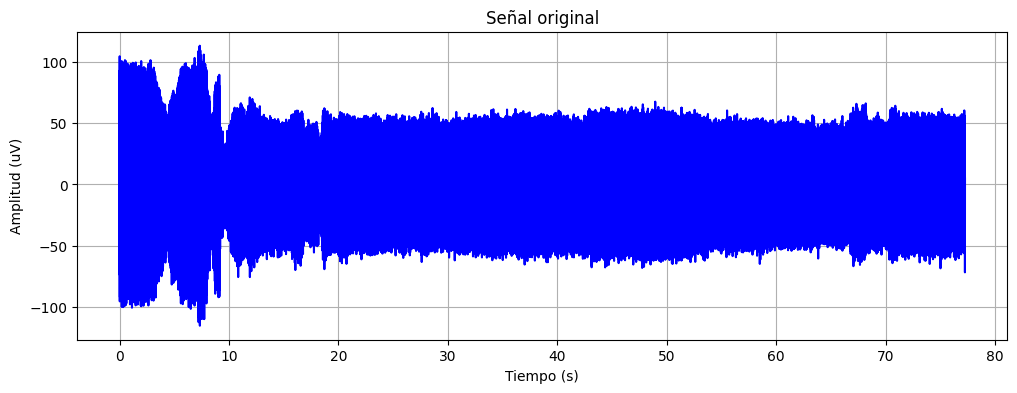

In [6]:
# 1. Cargar archivo .txt desde tu Drive (ajusta ruta)
file_path = "REPOSO 1.txt"

# 2. Leer el archivo, saltando encabezado
with open(file_path, "r") as f:
    lines = f.readlines()
    header_lines = [i for i, line in enumerate(lines) if line.startswith("#")]
    data_start = header_lines[-1] + 1

data = pd.read_csv(file_path, sep="\t", skiprows=data_start, header=None)
data.columns = ["nSeq", "I1", "I2", "O1", "O2", "A1", "unused"]

# 3. Extraer la señal RAW del canal A1
raw_emg = data["A1"].values

# 4. Filtro pasa banda
def bandpass_filter(signal, lowcut=20.0, highcut=450.0, fs=1000.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered = bandpass_filter(raw_emg)
fs = 1000
t = np.arange(len(raw_emg)) / fs  # eje de tiempo en segundos

# 5. Señal original
plt.figure(figsize=(12, 4))
plt.plot(t, filtered, label='EMG original)', color='blue')
plt.title("Señal original")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (uV)")
plt.grid(True)
plt.show()



FILTRADO BUTTERWORTH

Orden mínimo: 12
Frecuencia de corte normalizada: 0.0633


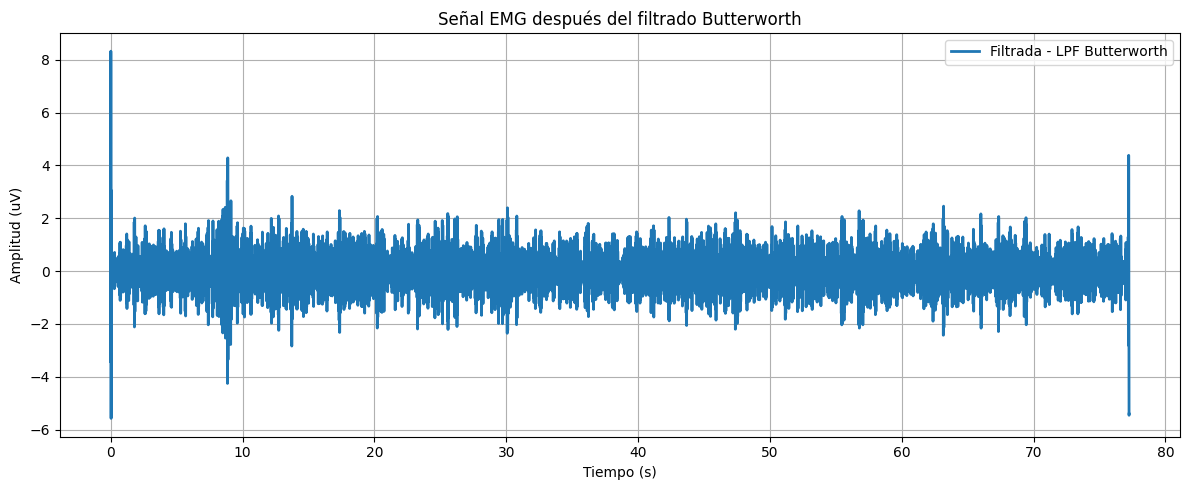

In [12]:
# 1. Parámetros del filtro
fs = 1000  # frecuencia de muestreo
nyq = fs / 2

fp = 188 / (2 * np.pi)  # ≈ 29.93 Hz
fs_rej = 300 / (2 * np.pi)  # ≈ 47.75 Hz

wp = fp / nyq  # frecuencia de paso normalizada
ws = fs_rej / nyq  # frecuencia de rechazo normalizada

gpass = 1  # pérdida máxima en banda pasante (dB)
gstop = 40  # atenuación mínima en banda de rechazo (dB)

# 2. Calcular orden mínimo y frecuencia de corte
order, wn = buttord(wp, ws, gpass, gstop)
print(f"Orden mínimo: {order}")
print(f"Frecuencia de corte normalizada: {wn:.4f}")

# 3. Diseñar filtro Butterworth
b, a = butter(order, wn, btype='low')

# 4. Filtrar la señal
filtered_butter = filtfilt(b, a, filtered)

# 5. Graficar señal filtrada
plt.figure(figsize=(12, 5))
plt.plot(t,filtered_butter, label="Filtrada - LPF Butterworth", linewidth=2)
plt.title("Señal EMG después del filtrado Butterworth")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (uV)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

FILTRO CHEBYSHEV

Orden mínimo: 6
Frecuencia de corte normalizada: 0.0598


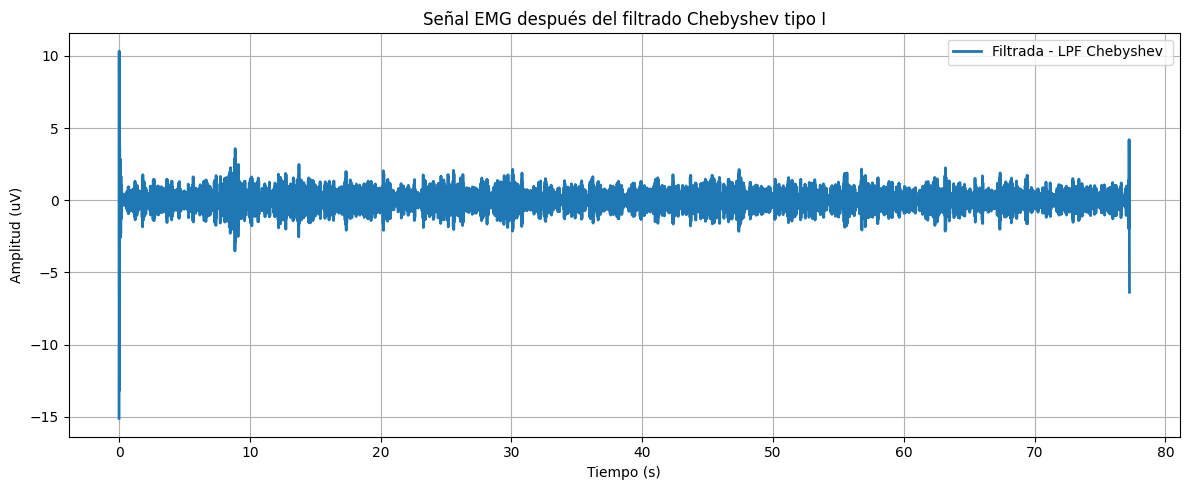

In [13]:
# 1. Parámetros del filtro (ya definidos en el filtro anterior)

# 2. Calcular orden mínimo y frecuencia de corte
order, wn = cheb1ord(wp, ws, gpass, gstop)
print(f"Orden mínimo: {order}")
print(f"Frecuencia de corte normalizada: {wn:.4f}")

# 3. Diseñar el filtro Chebyshev tipo I
b, a = cheby1(order, gpass, wn, btype='low')

# 4. Aplicar a tu señal EMG (raw_emg debe estar definido previamente)
filtered_cheby = filtfilt(b, a, filtered)

# 5. Graficar señal filtrada
plt.figure(figsize=(12, 5))
plt.plot(t,filtered_cheby, label="Filtrada - LPF Chebyshev ", linewidth=2)
plt.title("Señal EMG después del filtrado Chebyshev tipo I")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (uV)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



COMPARACIÓN RESPUESTA EN FRECUENCIA

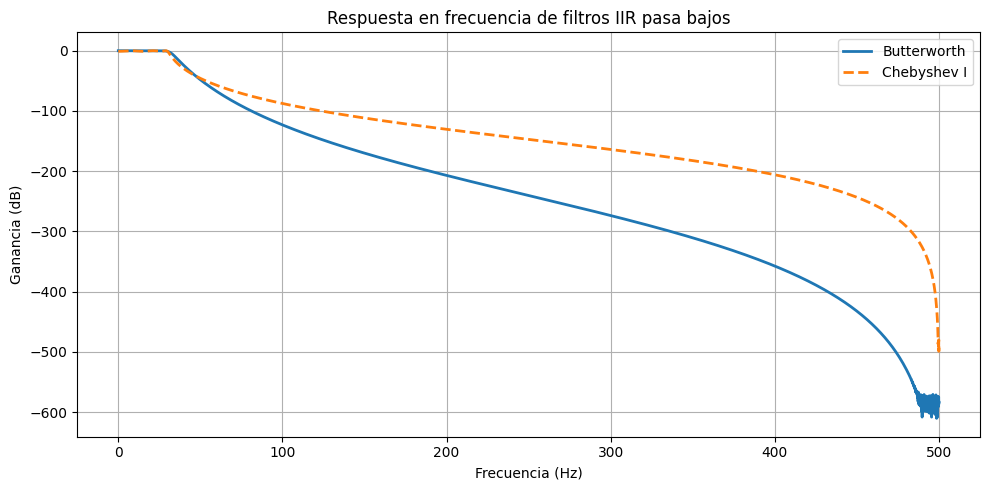

In [10]:
# Filtro Butterworth
order_butter, wn_butter = buttord(wp, ws, gpass, gstop)
b_butter, a_butter = butter(order_butter, wn_butter, btype='low')
w_butter, h_butter = freqz(b_butter, a_butter, worN=8000)

# Filtro Chebyshev tipo I
order_cheby, wn_cheby = cheb1ord(wp, ws, gpass, gstop)
b_cheby, a_cheby = cheby1(order_cheby, gpass, wn_cheby, btype='low')
w_cheby, h_cheby = freqz(b_cheby, a_cheby, worN=8000)

# Gráfica comparativa
plt.figure(figsize=(10, 5))
plt.plot(w_butter * nyq / np.pi, 20 * np.log10(abs(h_butter)), label='Butterworth', linewidth=2)
plt.plot(w_cheby * nyq / np.pi, 20 * np.log10(abs(h_cheby)), label='Chebyshev I', linestyle='--', linewidth=2)
plt.title("Respuesta en frecuencia de filtros IIR pasa bajos")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Ganancia (dB)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

COMPARACIÓN SEÑALES FILTRADAS

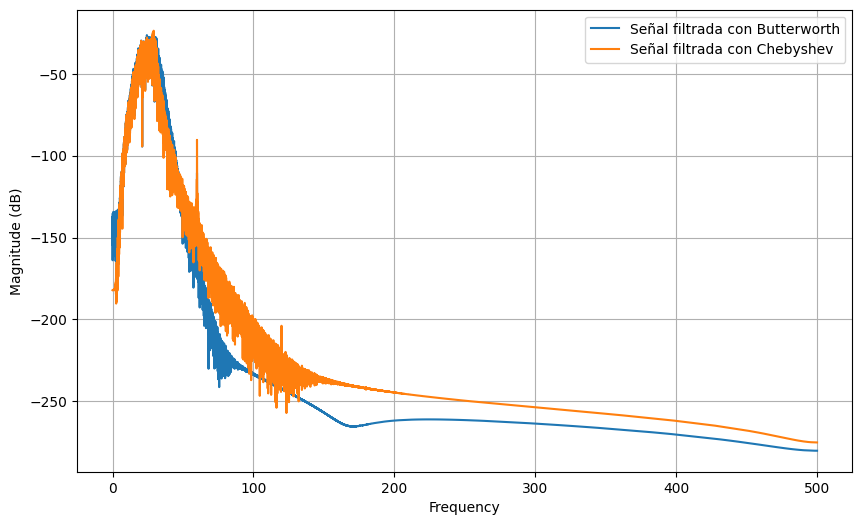

In [17]:
plt.figure(figsize=(10, 6))
plt.magnitude_spectrum(filtered_butter, scale='dB',Fs=fs, label='Señal filtrada con Butterworth')
plt.magnitude_spectrum(filtered_cheby, scale='dB',Fs=fs, label='Señal filtrada con Chebyshev')
plt.grid()
plt.legend()